In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import ase
from ase.io import read,write
from ase.visualize import view
import sys,os
from glob import glob
from copy import copy
from tqdm import tqdm_notebook
import cPickle as pck

In [3]:
sys.path.insert(0,'/local/git/ml_tools/')

In [4]:
import quippy as qp

In [5]:
import sh

In [6]:
import spglib as spg

In [7]:
from distutils.sysconfig import get_python_lib
print(get_python_lib())
os.path.join(get_python_lib(),'autograd')

/home/musil/miniconda/envs/gap/lib/python2.7/site-packages


'/home/musil/miniconda/envs/gap/lib/python2.7/site-packages/autograd'

In [8]:
def get_sp_mapping(frames,sp):
    ii = 0
    fid2gids = {it:[] for it in range(len(frames))}
    for iframe,cc in enumerate(frames):
        for ss in cc.get_atomic_numbers():
            if ss == sp:
                fid2gids[iframe].append(ii)
                ii += 1
    return fid2gids


In [9]:
from ml_tools.descriptors.quippy_interface import RawSoapQUIP
from ml_tools.models.KRR import KRR,TrainerCholesky,KRRFastCV
from ml_tools.models.pipelines import RegressorPipeline
from ml_tools.models.handlers import HashJsonHandler
from ml_tools.kernels.kernels import KernelPower,KernelSparseSoR,KernelSum
from ml_tools.io_utils import load_pck
from ml_tools.utils import get_mae,get_rmse,get_sup,get_spearman,get_score
from ml_tools.split.spliter import KFold,EnvironmentalKFold,LCSplit,ShuffleSplit,EnvironmentalShuffleSplit
from ml_tools.model_selection.scorer import CrossValidationScorer
from ml_tools.model_selection.gs import GridSearch
from ml_tools.base import KernelBase,BaseEstimator,TransformerMixin
from ml_tools.math_utils.optimized import power
from ml_tools.compressor.fps import FPSFilter
from ml_tools.compressor.filter import SymmetryFilter
from ml_tools.base import np,sp

# create new structure set

In [48]:
ff = read('data/CSD500-r0.025_140818.xyz',index=':')
len(ff)
for ii in ff:
    ii.info['rattle_AA'] = 0.025

In [49]:
dd = read('data/CSD500-r0.05_tmp_new.xyz',index=':')
len(dd)
for ii in dd:
    ii.info['rattle_AA'] = 0.05

In [50]:
frames = ff+dd
len(frames)

940

In [51]:
mapping = get_sp_mapping(frames,sp=1)

In [54]:
np.random.seed(10)
iiii = range(len(frames))
np.random.shuffle(iiii)
ids = iiii[:440]
iiii = range(len(frames))
iiii = list(set(iiii).difference(ids))
print len(iiii)
nenv = 0
for ii in ids:
    nenv += len(mapping[ii])
print nenv
nenv = 0
for ii in iiii:
    nenv += len(mapping[ii])
print nenv

500
26743
28749


In [46]:
frames_holout = [frames[ii] for ii in ids]
frames_train = [frames[ii] for ii in iiii]

In [55]:
write('CSD500-r_train.xyz',frames_train)
write('CSD440-r_holdout.xyz',frames_holout)
write('CSD940-r.xyz',frames)

# test global prop learning

In [9]:
fn = 'data/paracetamol_polymorph_I_200_with_alphas.xyz'
frames_train = read(fn,index=':100')
frames_test = read(fn,index='100:')
fn ='data/trace_alpha_200.dat'
prop = np.loadtxt(fn)
y_train = prop[:100]
y_test = prop[100:]

In [11]:
delta = 0.1
zeta = 2
jitter = 1e-8

soap_params = dict(rc=4, nmax=8, lmax=6, awidth=0.3,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=[1,6,7,8],nocenters=[],
                   fast_avg=False,is_sparse=False,disable_pbar=False)

kernel = KernelSum(KernelPower(zeta))
trainer = TrainerCholesky(memory_efficient=True)
representation = RawSoapQUIP(**soap_params)
krr = KRR(jitter,delta,trainer)

In [12]:
rawsoaps = representation.transform(frames_train)

HBox(children=(IntProgress(value=0, description=u'RawSoap'), HTML(value=u'')))

In [13]:
X_train = dict(feature_matrix=rawsoaps,strides=representation.strides)
kk = kernel.transform(X_train)
krr.fit(kk,y_train)

In [14]:
rawsoaps_test = representation.transform(frames_test)
X_test = dict(feature_matrix=rawsoaps_test,strides=representation.strides)
kk_test = kernel.transform(X_test,X_train=X_train)
y_pred = krr.predict(kk_test)
get_score(y_pred,y_test)

HBox(children=(IntProgress(value=0, description=u'RawSoap'), HTML(value=u'')))

(3.4921682051812764,
 4.560704429788471,
 14.564433112401616,
 0.8605418154554578,
 0.8074767476747675)

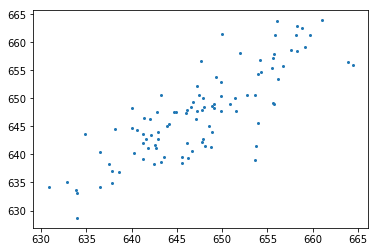

In [15]:
plt.plot(y_pred,y_test,'o',ms=2)

In [16]:
4.3594992/np.std(y_test)

0.555613308482012

# FPS selection of the samples

In [10]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames_train = read(fn,index=':10')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
prop = []
for cc in frames_train:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y_train = np.array(prop)

In [12]:
delta = np.std(y_train)
zeta = 2
Nselect = 6

soap_params = dict(rc=5, nmax=12, lmax=9, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kernel = KernelPower(zeta,delta)
representation = RawSoapQUIP(**soap_params)
compressor = FPSFilter(Nselect,kernel,act_on='sample',precompute_kernel=True,disable_pbar=True)

In [16]:
rawsoaps = representation.transform(frames_train)
rawsoaps.shape

(650, 11761)

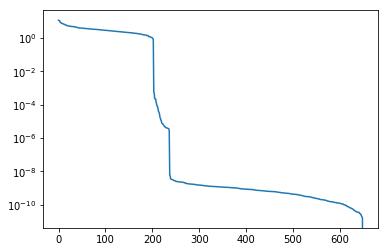

In [15]:
compressor.fit(rawsoaps,dry_run=True)
compressor.plot()

In [17]:
Nselect = 250
compressor = FPSFilter(Nselect,kernel,act_on='sample',precompute_kernel=True,disable_pbar=True)
compressor.fit(rawsoaps)

FPSFilter(Nselect=250, act_on='sample',
     kernel=KernelPower(delta=3.222900421236607, zeta=2))

# Filter equivalent atoms

In [32]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames_train = read(fn,index=':50')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
prop = []
for cc in frames_train:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y_train = np.array(prop)

In [33]:
delta = np.std(y_train)
zeta = 2

soap_params = dict(rc=5, nmax=9, lmax=6, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)
representation = RawSoapQUIP(**soap_params)

In [19]:
rawsoaps = representation.transform(frames_train)

In [22]:
filt = SymmetryFilter(threshold=1e-4,species=[sp])
X_filt, y_filt = filt.fit_transform(dict(frames=frames_train,feature_matrix=rawsoaps),y=y_train)
print X_filt.shape,filt.strides[-1]
print len(filt.filter_ids_inv)
a,b = filt.inverse_transform(X_filt,y_filt)
print np.allclose(rawsoaps,a,atol=1e-4),np.allclose(y_train,b,atol=1e-4)



(7543, 11761) 7543
17857
True False


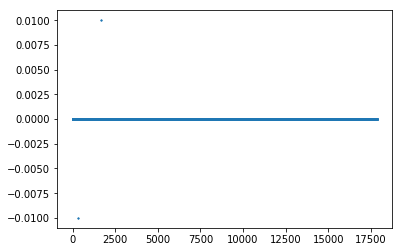

In [21]:
plt.plot(y_train-b,'o',ms=1)

# CV

In [35]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames = read(fn,index=':10')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
prop = []
for cc in frames:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y = np.array(prop)
mapping = get_sp_mapping(frames,sp)

In [36]:
delta = np.std(y)
zeta = 2
jitter = 1e-8

soap_params = dict(rc=5, nmax=12, lmax=9, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kernel = KernelPower(zeta,delta)
trainer = TrainerCholesky(memory_efficient=True)
representation = RawSoapQUIP(**soap_params)
krr = KRR(jitter,trainer)

cv = EnvironmentalKFold(n_splits=6,random_state=10,shuffle=True,mapping=mapping)


In [37]:
rawsoaps = representation.transform(frames)

In [40]:

def compute_cross_validation_error(rawsoaps,y,kernel,jitter,cv):
    K = kernel.transform(rawsoaps)
    Q = K + np.diag(jitter*np.ones(K.shape[0]))
    Q_inv = np.linalg.inv(Q)
    alpha = np.dot(Q_inv,y)
    Cii = []
    beta = np.zeros(alpha.shape)
    error = np.zeros(y.shape)
    for train,test in cv.split(rawsoaps):
        Cii = Q_inv[np.ix_(test,test)]
        beta = np.linalg.solve(Cii,alpha[test])
        error[test] = beta # beta = y_true - y_pred 
    return error

In [43]:
error = compute_cross_validation_error(rawsoaps,y,kernel,jitter,cv)
print np.sqrt(np.mean(error**2))
print error

HBox(children=(IntProgress(value=0, max=6), HTML(value=u'')))


1.975558350171262
[-5.38835793e-01 -5.44934236e-01 -5.38827481e-01 -5.44942394e-01
  1.19339224e+00  1.17967875e+00  1.19341209e+00  1.17966460e+00
 -6.77844718e-01 -6.85082210e-01 -6.77843657e-01 -6.85076229e-01
  7.32893975e-01  7.38643107e-01  7.32909128e-01  7.38648855e-01
  9.67222176e-01  9.63415471e-01  9.67225483e-01  9.63418982e-01
  1.44494831e+00  1.44281050e+00  1.44496489e+00  1.44281265e+00
 -4.01776629e-01 -4.31315976e-01 -4.01763944e-01 -4.31289025e-01
 -1.52790804e+00 -1.53104061e+00 -1.52791281e+00 -1.53105148e+00
 -2.47070846e+00 -2.47447121e+00 -2.47072362e+00 -2.47448512e+00
  1.26198601e+00  1.26653595e+00  1.26199495e+00  1.26653194e+00
 -1.44213284e+00 -1.44081971e+00 -1.44212790e+00 -1.44081305e+00
 -1.91712728e+00 -1.91781939e+00 -1.91712609e+00 -1.91782232e+00
  2.58334975e-01  2.45891594e-01  2.58329186e-01  2.45887107e-01
 -9.43765082e-01 -9.42280688e-01 -9.43761392e-01 -9.42282589e-01
 -1.67182781e+00 -1.68471648e+00 -1.67182975e+00 -1.68471589e+00
 -2.63

# LC

In [36]:
sp = 1
path = './data/'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames = read(fn,index=':30')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
prop = []
for cc in frames:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y = np.array(prop)
mapping = get_sp_mapping(frames,sp)

In [40]:
delta = np.std(y)*0.1
zeta = 2
jitter = 1e-6

soap_params = dict(rc=3.5, nmax=9, lmax=9, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kernel = KernelPower(zeta)
trainer = TrainerCholesky(memory_efficient=False)
representation = RawSoapQUIP(**soap_params)
krr = KRR(jitter,delta,trainer)


In [41]:
rawsoaps = representation.transform(frames)
K = kernel.transform(rawsoaps)

In [42]:
lc = LCSplit(ShuffleSplit, n_repeats=[5,5],train_sizes=[5,10],test_size=10, random_state=10,mapping=mapping)


In [34]:
len(test)

666

In [43]:
score = []
for train,test in tqdm_notebook(lc.split(rawsoaps),total=lc.n_splits):
    k_train = K[np.ix_(train,train)]
    y_train = y[train]
    k_test = K[np.ix_(test,train)]
    krr.fit(k_train,y_train)
    y_pred = krr.predict(k_test)
    score.append(get_score(y_pred,y[test]))
score

HBox(children=(IntProgress(value=0, max=10), HTML(value=u'')))

[{'CORR': 0.8403507703470844,
  'MAE': 1.389410772329679,
  'R2': 0.5333404743827472,
  'RMSE': 2.1830958916795793,
  'SUP': 12.244168276105796},
 {'CORR': 0.8606352302813769,
  'MAE': 1.6069458357222093,
  'R2': 0.616605583819458,
  'RMSE': 2.1421459295171763,
  'SUP': 6.966962762624689},
 {'CORR': 0.8710083364918597,
  'MAE': 1.2681521165879948,
  'R2': 0.7208721416591675,
  'RMSE': 1.7097268471927805,
  'SUP': 6.157925711387847},
 {'CORR': 0.839996431376945,
  'MAE': 1.6144580213617208,
  'R2': 0.6508305875957998,
  'RMSE': 2.146810455637819,
  'SUP': 10.42539318114158},
 {'CORR': 0.8350615436171914,
  'MAE': 1.417988572007206,
  'R2': 0.7273851533649753,
  'RMSE': 1.8593397869374002,
  'SUP': 8.1286540219269},
 {'CORR': 0.8659111452102873,
  'MAE': 1.0812968538137122,
  'R2': 0.7660228361095491,
  'RMSE': 1.46739444090563,
  'SUP': 6.123992319889993},
 {'CORR': 0.8857659939425754,
  'MAE': 1.1417895941018574,
  'R2': 0.7603913968053839,
  'RMSE': 1.6885729159180853,
  'SUP': 9.2194

In [15]:
35000**2*8/1e9

9.8

# Procedure of the Shift ML 1 paper (updated)

## detect outlier in the train set

In [49]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames_train = read(fn,index=':50')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)
prop = []
for cc in frames_train:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y_train = np.array(prop)


In [50]:
delta = np.std(y_train)*0.1
zeta = 2
jitter = 1e-8

soap_params = dict(rc=3.5, nmax=9, lmax=6, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kernel = KernelPower(zeta,delta)
representation = RawSoapQUIP(**soap_params)
filt = SymmetryFilter(threshold=1e-4,species=[sp])


In [51]:
rawsoaps = representation.transform(frames_train)

X_filt, y_filt = filt.fit_transform(dict(frames=frames_train,feature_matrix=rawsoaps),y=y_train)
Kmat = kernel.transform(X_filt)

In [52]:
mapping = {}
for iframe,(st,nd) in enumerate(zip(filt.strides[:-1],filt.strides[1:])):
    mapping[iframe] = range(st,nd)

In [91]:
np.random.seed(10)
seeds = np.random.randint(low=0,high=1000,size=(100,))
preds = []
for seed in tqdm_notebook(seeds):
    cv = EnvironmentalKFold(n_splits=3,random_state=seed,shuffle=True,mapping=mapping)
    krr = KRRFastCV(jitter,cv)
    
    krr.fit(Kmat,y_filt)
    
    yp_filt = krr.predict()
    _,y_pred = filt.inverse_transform(y=yp_filt)
    preds.append(y_pred)
preds = np.array(preds)

HBox(children=(IntProgress(value=0), HTML(value=u'')))

In [92]:
m = np.mean(preds-y_train,axis=0)
s = np.std(preds-y_train,axis=0)

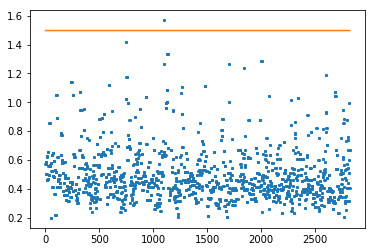

In [93]:
plt.plot(s,'o',ms=2,)
plt.plot(3*s.mean()*np.ones(len(m)),'-',ms=2,)

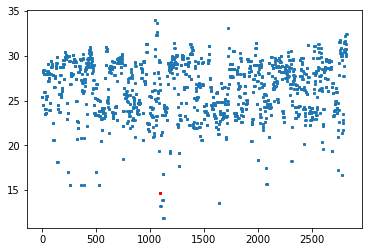

In [94]:
plt.plot(y_train,'o',ms=2)
plt.plot(np.where(s>3*s.mean())[0],y_train[s>3*s.mean()],'ro',ms=2,)

In [95]:
mapping_sp = get_sp_mapping(frames_train,sp)

iii = np.where(s>3*s.mean())[0]
suspicious_center = iii
sp,name=1,'ccsd'
suspicious_frame = []
for icenter in iii:
    for iframe,centers in mapping_sp.iteritems():
        if icenter in centers:
            suspicious_frame.append(iframe)
            break

#print np.unique(suspicious_frame)
suspicious_frame = np.unique(suspicious_frame)
suspicious_frame

array([18])

## FPS filtering

In [112]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames_train = read(fn,index=':50')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)

In [113]:
suspicious_frames = [18]
for idx in suspicious_frames:
    frames_train.pop(idx)
print len(frames_train)

prop = []
for cc in frames_train:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y_train = np.array(prop)

49


In [114]:
delta = np.std(y_train)
zeta = 2
Nselect = 6

soap_params = dict(rc=5, nmax=12, lmax=9, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kernel = KernelPower(zeta,delta)
representation = RawSoapQUIP(**soap_params)
compressor = FPSFilter(Nselect,kernel,act_on='sample',precompute_kernel=True,disable_pbar=True)
filt = SymmetryFilter(threshold=1e-4,species=[sp])

In [115]:
rawsoaps = representation.transform(frames_train)

X_filt, y_filt = filt.fit_transform(dict(frames=frames_train,feature_matrix=rawsoaps),y=y_train)


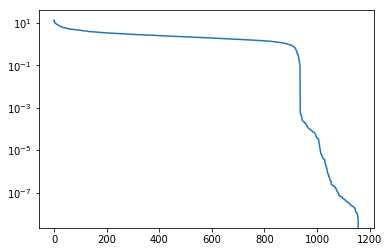

In [116]:
compressor.fit(X_filt,dry_run=True)
compressor.plot()

## CV score for a model

In [100]:
sp = 1
path = './'
xyzPath = path + ''
fn = xyzPath + 'CSD500.xyz'
frames_train = read(fn,index=':50')
global_species=[1, 6, 7, 8]
nocenters = copy(global_species)
nocenters.remove(sp)

In [101]:
suspicious_frames = [18]
for idx in suspicious_frames:
    frames_train.pop(idx)
print len(frames_train)

49


In [102]:
prop = []
for cc in frames_train:
    numb = cc.get_atomic_numbers()
    prop.extend(cc.get_array('CS')[numb==sp])
y_train = np.array(prop)

In [107]:
delta = np.std(y_train)*0.1
zeta = 2
jitter = 1e-8
Nselect = 1000

soap_params = dict(rc=3.5, nmax=9, lmax=6, awidth=0.4,
                    cutoff_transition_width=0.5,
                    cutoff_dexp=0, cutoff_scale=1,cutoff_rate=1,
                    centerweight=1.,global_species=global_species,nocenters=nocenters,
                   fast_avg=False,is_sparse=False,disable_pbar=True)

kernel = KernelPower(zeta,delta)
representation = RawSoapQUIP(**soap_params)
filt = SymmetryFilter(threshold=1e-4,species=[sp])
compressor = FPSFilter(Nselect,kernel,act_on='sample',precompute_kernel=True,disable_pbar=True)



In [108]:
rawsoaps = representation.transform(frames_train)

X_filt, y_filt = filt.fit_transform(dict(frames=frames_train,feature_matrix=rawsoaps),y=y_train)
Kmat = kernel.transform(X_filt)

In [109]:
mapping = {}
for iframe,(st,nd) in enumerate(zip(filt.strides[:-1],filt.strides[1:])):
    mapping[iframe] = range(st,nd)

In [110]:

cv = EnvironmentalKFold(n_splits=10,random_state=seed,shuffle=True,mapping=mapping)
krr = KRRFastCV(jitter,cv)

In [111]:

krr.fit(Kmat,y_filt)

yp_filt = krr.predict()
_,y_pred = filt.inverse_transform(y=yp_filt)

get_score(y_train,y_pred)

(0.7476413086559425,
 0.9923627295631735,
 6.964805883089406,
 0.902222396797154,
 0.9456986647400127)